In [1]:
import sys
import os
import cv2
import matplotlib.pyplot as plt
import psutil
import numpy as np
import pandas as pd
import torch

# Add the root of the project to the path
sys.path.append(os.path.abspath("D:\\burtm\\Visual_studio_code\\PD_related_projects"))

In [2]:
source_path="D:\\burtm\\Visual_studio_code\\PD_related_projects"
#train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_w_image_paths.csv")
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_w_image_paths.csv")

In [3]:
train_df.head()

,writer,same_text,isEng,train,file_name,male
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
1,1,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
2,1,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
3,1,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
4,2,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0


In [3]:
test_i=3
file_path = train_df.loc[test_i, 'file_name']
# Load the image in grayscale
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

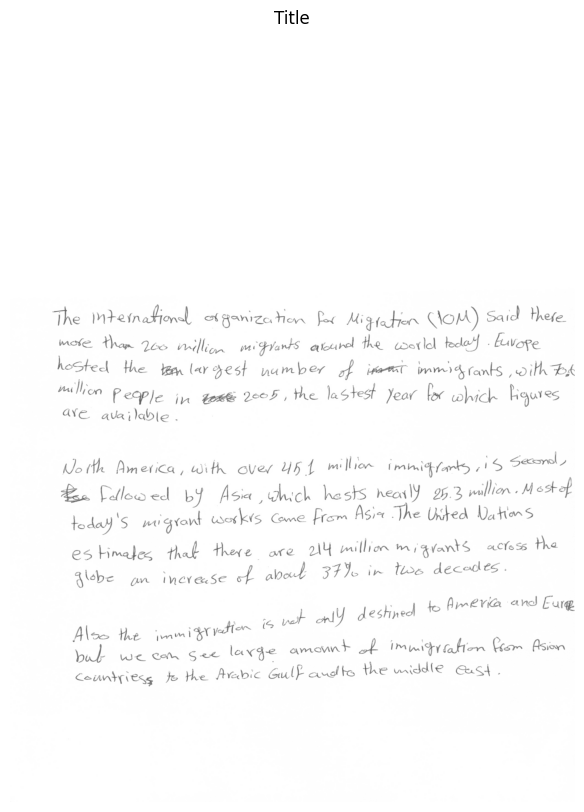

In [4]:
def plot_image(image, convert=False):
    # Convert the image to RGB for plotting
    if convert:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image.copy()
    # Plot the image with keypoints
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Title")
    plt.show()
plot_image(img, convert=True)

# projection profile approach

Horizontal Projection shape: (3365,)


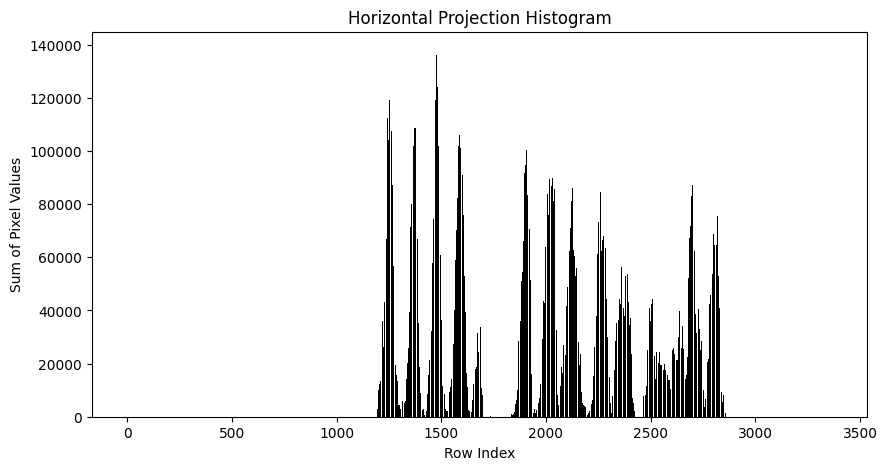

In [8]:
# Step 1: Binarize the image using adaptive threshold
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 15, 10)
#plot_image(binary, convert=True)

# Step 2: Line segmentation using horizontal projection
horizontal_projection = np.sum(binary, axis=1)
print("Horizontal Projection shape:", horizontal_projection.shape)
plt.figure(figsize=(10, 5))
plt.bar(range(len(horizontal_projection)), horizontal_projection, color='black')
plt.title("Horizontal Projection Histogram")
plt.xlabel("Row Index")
plt.ylabel("Sum of Pixel Values")
plt.show()

lines = []
start = None
min_sum = 0.1 * np.max(horizontal_projection)  # Minimum sum to consider a line

for i, row_sum in enumerate(horizontal_projection):
    if row_sum > min_sum and start is None:
        start = i
    elif row_sum < min_sum and start is not None:
        lines.append((start, i))
        start = None

if start is not None:
    lines.append((start, len(binary)))


In [9]:
# Step 3: Segment lines and within each line, segment words
line_images = []
word_images = []

for idx, (y1, y2) in enumerate(lines):
    line_img = binary[y1:y2, :]
    line_images.append((y1,y2))

    # Word segmentation using vertical projection on each line
    vertical_projection = np.sum(line_img, axis=0)
    word_start = None
    words_in_line = []

    for j, col_sum in enumerate(vertical_projection):
        if col_sum > 0 and word_start is None:
            word_start = j
        elif col_sum == 0 and word_start is not None and j - word_start > 200:
            words_in_line.append((word_start, j))
            word_start = None

    if word_start is not None:
        words_in_line.append((word_start, line_img.shape[1]))

    # Extract words from the line image
    for w_idx, (x1, x2) in enumerate(words_in_line):
        #word_img = line_img[:, x1:x2]
        word_images.append((y1, y2, x1, x2))
        # Optionally show or save each word
        # show_image(f"Line {idx+1} Word {w_idx+1}", word_img)

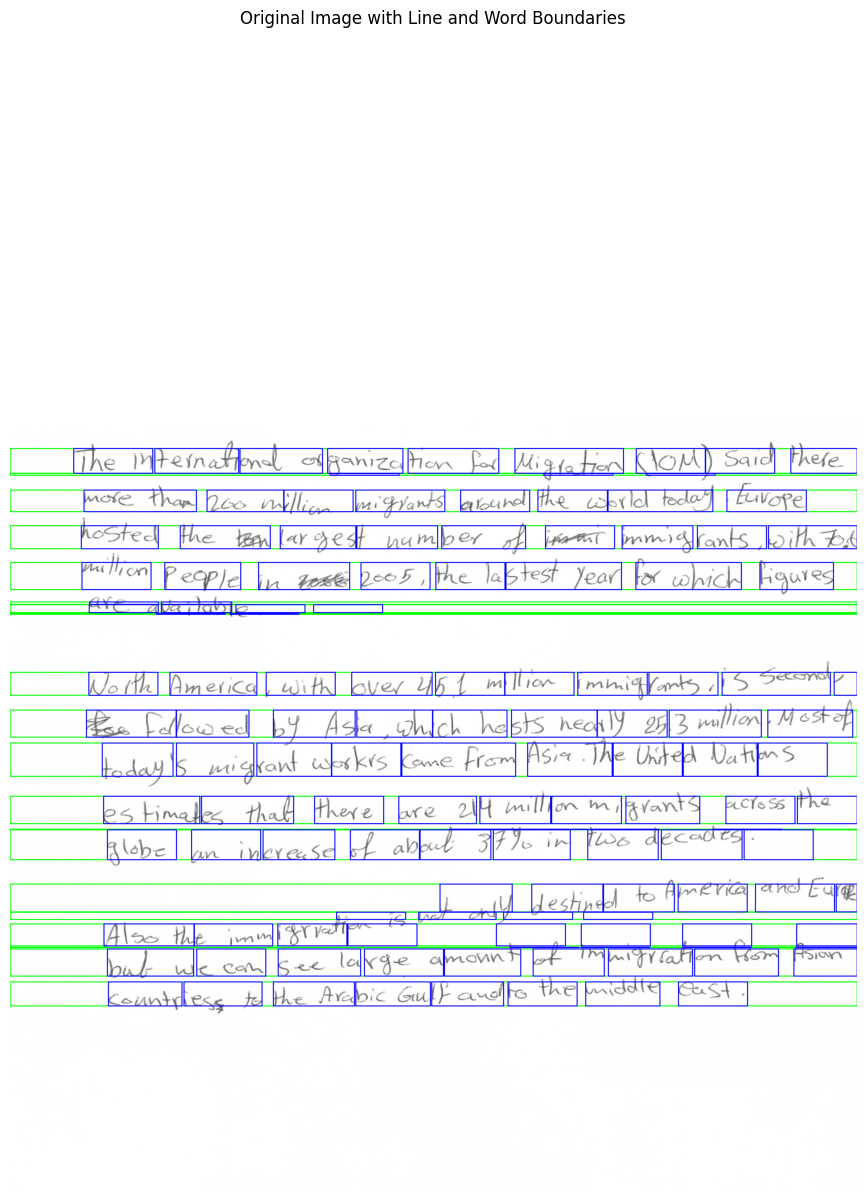

In [10]:
# Create a copy of the original image to draw on
image_with_boxes = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw line boundaries
for y1, y2 in lines:
    cv2.rectangle(image_with_boxes, (0, y1), (image_with_boxes.shape[1], y2), (0, 255, 0), 2)

# Draw word bounding boxes
for y1, y2, x1, x2 in word_images:
    cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the image with the bounding boxes
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original Image with Line and Word Boundaries")
plt.show()

# connected components approach

In [ ]:
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 15, 10)

# Step 1: Connected Components Analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Filter out small noise blobs
min_area = 10  # tweak based on image resolution
components = []
for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]
    if area >= min_area:
        components.append((x, y, w, h, area))

# Step 2: Group into lines by y-coordinate proximity
components.sort(key=lambda b: b[1])  # sort by y (top of bounding box)
lines = []
line_threshold = 20  # vertical spacing threshold in pixels

for comp in components:
    x, y, w, h, _ = comp
    assigned = False
    for line in lines:
        if abs(y - line['y_mean']) < line_threshold:
            line['boxes'].append(comp)
            line['y_values'].append(y)
            line['y_mean'] = np.mean(line['y_values'])
            assigned = True
            break
    if not assigned:
        lines.append({'boxes': [comp], 'y_values': [y], 'y_mean': y})

# Step 3: Within each line, group into words by x-coordinate gaps
word_images = []

for i, line in enumerate(lines):
    boxes = sorted(line['boxes'], key=lambda b: b[0])  # sort by x
    word = [boxes[0]]
    for j in range(1, len(boxes)):
        prev = boxes[j - 1]
        curr = boxes[j]
        gap = curr[0] - (prev[0] + prev[2])
        if gap < 30:  # horizontal threshold for word gap
            word.append(curr)
        else:
            word_images.append(word)
            word = [curr]
    word_images.append(word)  # add last word

    # Optionally visualize words in line
    for k, word_box_group in enumerate(word_images):
        xs = [b[0] for b in word_box_group]
        ys = [b[1] for b in word_box_group]
        ws = [b[2] for b in word_box_group]
        hs = [b[3] for b in word_box_group]

        x1 = min(xs)
        y1 = min(ys)
        x2 = max([x + w for x, w in zip(xs, ws)])
        y2 = max([y + h for y, h in zip(ys, hs)])

        word_img = binary[y1:y2, x1:x2]
        show_image(f"Line {i+1} Word {k+1}", word_img)


# test trocr

In [5]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database
'''url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")'''
# Select one word image from the word_images list

#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',force_download=True) #force download clear the cache and redownload the model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

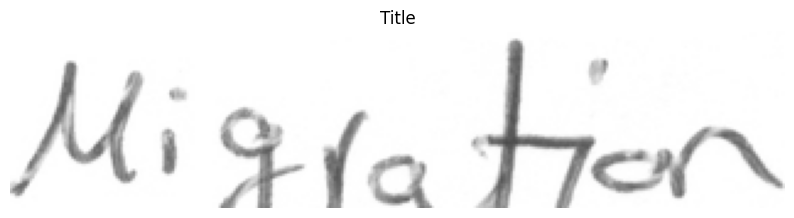

In [11]:
for i in range(len(word_images)):
    y1, y2, x1, x2 = word_images[i]
    if x2-x1 > 300:  # Filter out small components
        word_img = img[y1:y2, x1:x2]
        break
    else:
        pass

# Convert the selected word image to RGB format
image = cv2.cvtColor(word_img, cv2.COLOR_GRAY2RGB)
plot_image(image, convert=False)

In [12]:
height, width = img.shape
print(f"Image Height: {height}, Image Width: {width}")

Image Height: 3365, Image Width: 2465


In [13]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

In [26]:
print(processor)

TrOCRProcessor:
- image_processor: DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: XLMRobertaTokenizer(name_or_path='microsoft/trocr-small-handwritten', vocab_size=64002, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=

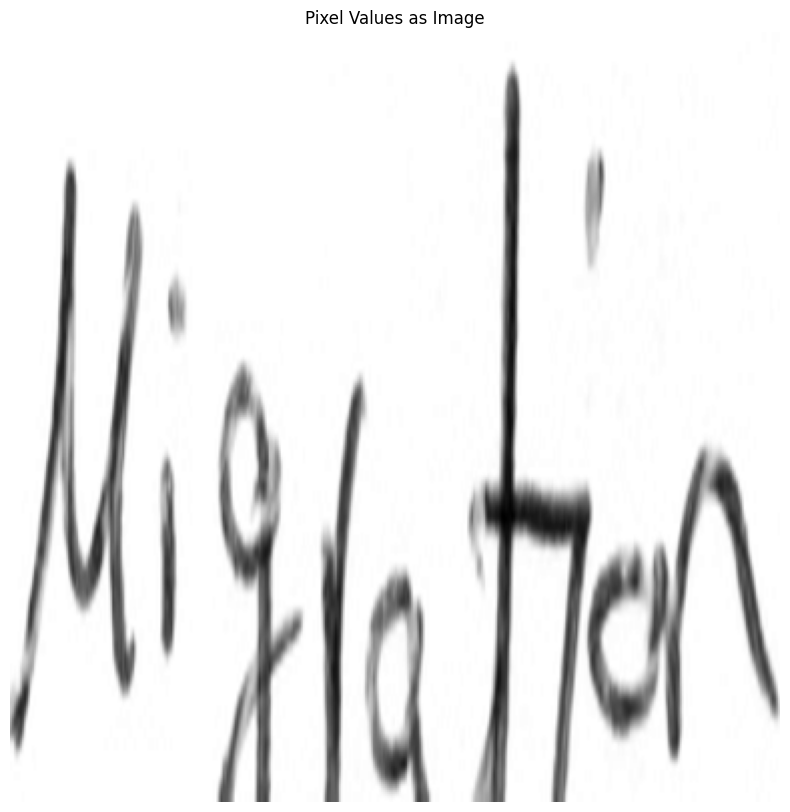

In [14]:
# Convert pixel_values tensor to NumPy array
pixel_values_np = pixel_values.squeeze().permute(1, 2, 0).numpy()

# Normalize to 0-255 for visualization
pixel_values_np = (pixel_values_np - pixel_values_np.min()) / (pixel_values_np.max() - pixel_values_np.min()) * 255
pixel_values_np = pixel_values_np.astype(np.uint8)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(pixel_values_np)
plt.axis('off')
plt.title("Pixel Values as Image")
plt.show()

In [15]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [16]:
print(generated_text)

Migration


In [59]:
print(model)


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [ ]:
print(model.config)


VisionEncoderDecoderConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/trocr-small-handwritten",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_attn_implementation_autoset": false,
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "relu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 384,
    "d_model": 256,
    "decoder_attention_heads": 8,
    "decoder_ffn_dim": 1024,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 6,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "f

In [61]:
print(model.encoder.config.use_cls_token if hasattr(model.encoder.config, "use_cls_token") else "No cls token info")

No cls token info


In [17]:
outputs = model.encoder(pixel_values=pixel_values)
last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, sequence_length, hidden_size)
print("Last hidden state shape:", last_hidden_state.shape)

Last hidden state shape: torch.Size([1, 578, 384])


In [18]:
patch_size = model.encoder.config.patch_size  # e.g., 16
image_size = model.encoder.config.image_size  # e.g., 224

num_patches = (image_size // patch_size) ** 2
print(num_patches)

576


In [19]:
from torch import nn

# Define the classifier model
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classification_head = nn.Linear(encoder.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.encoder(pixel_values=pixel_values)
        cls_token_output = outputs.last_hidden_state[:, 0, :]  # Extract the CLS token
        logits = self.classification_head(cls_token_output)
        return logits

# Create the classifier model
classifier = Classifier(model.encoder)

# Delete the original model to free up memory
del model

In [ ]:
print(classifier)


Classifier(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feat

In [82]:
print(classifier.encoder)

DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0-11): 12 x DeiTLayer(
        (attention): DeiTSdpaAttention(
          (attention): DeiTSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn)

In [76]:
for name, param in classifier.encoder.named_parameters():
    print(name)

embeddings.cls_token
embeddings.distillation_token
embeddings.position_embeddings
embeddings.patch_embeddings.projection.weight
embeddings.patch_embeddings.projection.bias
encoder.layer.0.attention.attention.query.weight
encoder.layer.0.attention.attention.query.bias
encoder.layer.0.attention.attention.key.weight
encoder.layer.0.attention.attention.key.bias
encoder.layer.0.attention.attention.value.weight
encoder.layer.0.attention.attention.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.layernorm_before.weight
encoder.layer.0.layernorm_before.bias
encoder.layer.0.layernorm_after.weight
encoder.layer.0.layernorm_after.bias
encoder.layer.1.attention.attention.query.weight
encoder.layer.1.attention.attention.query.bias
encoder.layer.1.attention.attention.key.weight
encod

In [ ]:
'''# Freeze all layers except the last self-attention module and the following layers
for name, param in classifier.encoder.named_parameters():
    if "layer.11" not in name and "layernorm" not in name and "pooler" not in name:
        param.requires_grad = False''' #i think in this way it would not freeze also many other layers because of 
#the name "layernorm" and "pooler"

In [83]:
def return_trainable_params(classifier):
    return sum(p.numel() for p in classifier.parameters() if p.requires_grad)

In [ ]:
'''#print the number of trainable parameters in the model
print("Number of trainable parameters in the model:")
trainable_params = return_trainable_params(classifier)
print(trainable_params)
#freeze all model parameters and print the trainable layers 
for name, param in classifier.named_parameters():
    param.requires_grad = False  # Freeze all parameters
print("Trainable parameters after freezing:")
trainable_params = return_trainable_params(classifier)
print(trainable_params)
# Unfreeze the last self-attention module and the following layers
classifier.encoder.encoder.layer[-1].requires_grad = True  # Unfreeze the last layer
classifier.encoder.layernorm.requires_grad = True  # Unfreeze the layer norm
classifier.encoder.pooler.requires_grad = True  # Unfreeze the pooler
classifier.classification_head.requires_grad = True  # Unfreeze the classification head
print("Trainable parameters after unfreezing:")
trainable_params = return_trainable_params(classifier)
print(trainable_params)'''

Number of trainable parameters in the model:
0
Trainable parameters after freezing:
0
Trainable parameters after unfreezing:
0


In [ ]:
# Iterate through the layers of a PyTorch model
from torch import nn

def print_model_layers(model):
    for name, module in model.named_modules():
        print(f"Layer Name: {name}, Layer Type: {type(module).__name__}")

# Example usage with the classifier model
print_model_layers(classifier)